In [42]:
import urllib3

def get_request(uri):
    ua = "Mozilla/5.0 (Linux; U; Android 2.2; en-us; Nexus One Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1"  
    h = {"User-Agent": ua}
    httpPool = urllib3.PoolManager()
    return httpPool.request('GET',uri,fields=None,headers=h)

In [43]:
import json

from bs4 import BeautifulSoup


with open('URL.json',"r") as f:
    urls = json.load(f)

DATA = list(map(lambda x: [x['name'],x['URL'],x['HTML'],x['class']],urls['periodicos']))

textos=[]
for dato in DATA:
    soup = BeautifulSoup(get_request(dato[1]).data,'html.parser')
    textos.append(list(map(lambda x:x.text,soup.find_all(dato[2],{"class":dato[3]}))))

In [49]:
textoLimpio = []
caracterBasura="\n"
textosSinCaracterBasura=[]
for value in textos:
    textosSinCaracterBasura.append([x.replace(caracterBasura,'') for x in value])

for index,value in enumerate(textos):
    textoLimpio.append(list(map(lambda x:" ".join(list(filter(lambda y:len(str(y))>3,(x.split(" "))))),textosSinCaracterBasura[index])))

In [58]:
textoUnido = [y for x in textoLimpio for y in x]

In [ ]:
# Menos óptimo

# PALABRA CON VALOR
palabraValor={}

# FRASES CON MÁS PUNTUACIÓN
frasesTotalValor=[]

for frase in textoUnido:
    fraseValores=[]
    for palabra in frase.split(" "):
        valor=0
        for frase in textoUnido:
            valor+=frase.count(palabra)
        palabraValor[palabra.lower()] = valor
        fraseValores.append(valor)
    frasesTotalValor.append(sum(fraseValores)/len(fraseValores))


In [ ]:
frasesTotalValor = list(map(lambda x:x/max(frasesTotalValor),frasesTotalValor))
frasesTotalValor

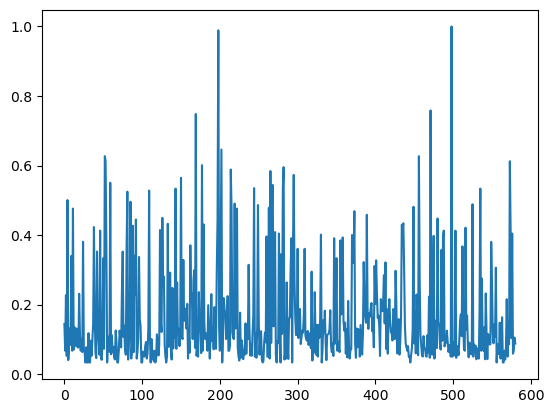

In [70]:
import matplotlib.pyplot as plt
from pandas import DataFrame

plt.plot(frasesTotalValor)